# Modelagem de tópicos com LDA no *Reddit* - Resultados de treinamento

Os treinamentos realizados no presente trabalho empregaram um *corpus* reduzido, contando com 2352 documentos. Cada documento é o corpo de uma submissão dentro do Reddit, mais especificamente, uma submissão dos subfóruns *r/brasil* e *r/desabafos*. Esse *dataset* foi obtido por meio das APIs do *Reddit* e do *Pushshifter*.

O treinamneto de modelos foi realizado utilizandos as bibliotecas de *machine learning* [scikit-learn](https://scikit-learn.org/stable/) e de *natural language processing* [gensim](https://radimrehurek.com/gensim/) para Python. Para um exemplo de implementação LDA com o *scikit-learn*, veja [este artigo](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py).

Os modelos foram treinados utilizando um *dataset* pré-processado por meio de bibliotecas como o *gensim*, [spaCy](https://spacy.io/) e [nltk](https://www.nltk.org/).

Para o treinamento realizado, foram removidos *tokens* que aparecem em menos de 1% dos documentos e *tokens* que aparecem em mais de 85% dos documentos. Além disso, a única categoria de palavras preservada no pré-processamento do *corpus* usado foi a categoria de <strong>substantivos</strong>.

A seguir, algumas visualizações são exibidas. Tais gráficos e imagens foram roduzidos com a *lib* [matplotlib](https://matplotlib.org/).

### Importações e configurações de ambiente

In [75]:
%load_ext autoreload
%autoreload 2

from utils.plots import plot_wordcloud, plot_graph, plot_wordcloud_by_word_probability, plot_pie_chart
import sys, time, json, os, joblib, numpy as np, pandas as pd
pd.options.display.max_colwidth = 100
from utils.notebook import create_dataframe_from_topics, get_topic_word_probability_pairs
import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

pyLDAvis.enable_notebook()

WORKDIR = f'{os.getcwd()}'.replace('src', '/')
BASE_MODELS_PATH = WORKDIR + "submissions_models/"
lda_results_csv = BASE_MODELS_PATH + "results/csv/lda/complete_results.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### *Corpus*

#### Comparando o *corpus* original com o pré-processado

Inicialmente, avaliemos o *corpus* obtido inicialmente com a coleta de postagens do *Reddit*. Tal *dataset* não sofreu qualquer tipo de pré-processamento em seu conteúdo.

In [76]:
original_dataset_file = open(BASE_MODELS_PATH + "reddit_gatherer.pt_submissions[original_dataset][2008_2020].json", "r")
original_dataset = json.load(original_dataset_file)
print(f'Total de documentos no corpus: {len(original_dataset)}')

Total de documentos no corpus: 3554


O *dataset* possui mais de 3000 documentos, ou seja, submissões. Ao exibir os registros, temos:

In [77]:
original_data_frame = pd.DataFrame.from_dict(original_dataset)
original_data_frame

,_id,clicked,created_utc,date,distinguished,edited,id,is_original_content,is_text_only,link_flair_template_id,...,permalink,score,body,spoiler,stickied,subreddit_id,subreddit_name,title,upvote_ratio,url
0,{'$oid': '5eec12482fd22c8cce4d12bd'},False,1.578186e+09,2020-01-04 21:56:37,None,False,ek5isq,False,True,4c194470-c37c-11e5-836f-0eb227bc2e49,...,/r/brasil/comments/ek5isq/galera_pensei_que_iria_ser_tudo_diferente_iria/,5,Abandonei meus amigos já nem eram muitos parei de sonhar e de criar espectativa alguma sério ach...,False,False,2qh9i,t5_2qh9i,"Galera pensei que iria ser tudo diferente, iria ser mais ativo, me socializar, fazer amigos etc,...",0.59,https://www.reddit.com/r/brasil/comments/ek5isq/galera_pensei_que_iria_ser_tudo_diferente_iria/
1,{'$oid': '5eec12502fd22c8cce4d12c6'},False,1.531415e+09,2018-07-12 13:55:10,None,False,8ybifp,False,False,32eb04de-4722-11e4-b035-12313b0b7e66,...,/r/brasil/comments/8ybifp/ayahuasca_diminui_sintomas_de_depressão_em/,3,,False,False,2qh9i,t5_2qh9i,Ayahuasca diminui sintomas de depressão em pesquisa brasileira,0.57,https://www1.folha.uol.com.br/ciencia/2018/06/ayahuasca-diminui-sintomas-de-depressao-em-pesquis...
2,{'$oid': '5eec125b2fd22c8cce4d12d2'},False,1.455806e+09,2016-02-18 12:27:53,None,False,46eyo3,False,False,None,...,/r/brasil/comments/46eyo3/mulher_que_rejeitou_desafio_da_maternidade_tem/,46,,False,False,2qh9i,t5_2qh9i,Mulher que rejeitou desafio da maternidade tem perfil no Facebook bloqueado e defende: ‘Não é de...,0.83,http://m.extra.globo.com/mulher/mulher-que-rejeitou-desafio-da-maternidade-tem-perfil-no-faceboo...
3,{'$oid': '5eec127a2fd22c8cce4d12f9'},False,1.588994e+09,2020-05-09 00:15:49,None,False,gg7q4m,False,True,0320c020-240b-11e9-ac26-0e300f2123be,...,/r/brasil/comments/gg7q4m/o_habitat_da_nossa_geração_é_a_precariedade_e_o/,27,"Para quem está muito assustado com o que ocorre hoje, uma reflexão: \n\nImagine que você nasceu ...",False,False,2qh9i,t5_2qh9i,"O habitat da nossa geração é a precariedade e o desemprego. No entanto, nenhum século foi fácil....",0.83,https://www.reddit.com/r/brasil/comments/gg7q4m/o_habitat_da_nossa_geração_é_a_precariedade_e_o/
4,{'$oid': '5eec12832fd22c8cce4d1303'},False,1.464913e+09,2016-06-02 21:11:52,None,1.46491e+09,4ma7sc,False,True,None,...,/r/brasil/comments/4ma7sc/estou_em_um_dilema_na_minha_vida_e_gostaria_que/,37,Eu estou no último ano da graduação e ando percebendo que vou sair de lá completamente sem amigo...,False,False,2qh9i,t5_2qh9i,"Estou em um dilema na minha vida e gostaria que vocês me ajudassem com opiniões, por favor",0.84,https://www.reddit.com/r/brasil/comments/4ma7sc/estou_em_um_dilema_na_minha_vida_e_gostaria_que/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,{'$oid': '5ef54a89c6c212b14b4b6d71'},False,1.585546e+09,2020-03-30 02:28:32,None,False,frkz8z,False,True,478d14b2-c05d-11e5-8ef5-0efe84381221,...,/r/desabafos/comments/frkz8z/como_eu_digo_para_os_meus_amigos_que_eu_não_to_bem/,1,"Tenho 16 anos e moro em Minas Gerais, comecei com um quadro depressivo desde os 11 anos, não sei...",False,False,395lw,t5_395lw,Como eu digo para os meus amigos que eu não to bem?,0.57,https://www.reddit.com/r/desabafos/comments/frkz8z/como_eu_digo_para_os_meus_amigos_que_eu_não_t...
3550,{'$oid': '5ef54ac9c6c212b14b4b6d90'},False,1.587347e+09,2020-04-19 22:47:47,None,False,g4jys9,False,True,None,...,/r/desabafos/comments/g4jys9/acho_que_sou_dependente_demais_de_outras_pessoas/,6,"Não sei explicar muito bem, mas parece que dependo de outras pessoas para _qualquer coisa,_ não ...",False,False,395lw,t5_395lw,"Acho que sou dependente demais de outras pessoas, e não faço ideia de como mudar isso.",0.88,https://www.reddit.com/r/desabafos/comments/g4jys9/acho_que_sou_dependente_demais_de_outras_pess...
3551,{'$oid': '5ef54ae4c6c212b14b4b6d9d'},False,1.592120e+09,2020-06-14 04:41:24,None,1.59217e+09,h8pgz0,False,True,None,...,/r/desabafos/comments/h8pgz0/meu_cachorro_se_foi/,8,"eu moro e

Como pode-se ver acima, algumas postagens não possuem campo *body* preenchido. Isso significa que tais postagens provavelmente tiveram seu conteúdo removido antes da coleta. Possivelmente, essas postagens foram deletadas por seus próprios autores, dado o potencial de conteúdo sensível representado por temas como depressão ou problemas emocionais.

Realizando pré-processamento no *corpus*, como *tokenização*, *lemmatização*, remoção de certas categorias de palavras e remoção de *stopwords*, nós teremos um *corpus* com 2352 documentos: 

In [78]:
dataset_file = open(BASE_MODELS_PATH + "reddit_gatherer.pt_submissions[2008_2020]_[preprocessed_dataset][nouns_only].json", "r")
dataset = json.load(dataset_file)
print(f'Total de documentos no corpus: {len(dataset)}')

Total de documentos no corpus: 2352


In [79]:
data_frame = pd.DataFrame.from_dict(dataset)
data_frame

,_id,clicked,created_utc,date,distinguished,edited,id,is_original_content,is_text_only,link_flair_template_id,...,permalink,score,body,spoiler,stickied,subreddit_id,subreddit_name,title,upvote_ratio,url
0,{'$oid': '5eec12482fd22c8cce4d12bd'},False,1.578186e+09,2020-01-04 21:56:37,None,False,ek5isq,False,True,4c194470-c37c-11e5-836f-0eb227bc2e49,...,/r/brasil/comments/ek5isq/galera_pensei_que_iria_ser_tudo_diferente_iria/,5,"[parar, espectativa, tentar]",False,False,2qh9i,t5_2qh9i,"Galera pensei que iria ser tudo diferente, iria ser mais ativo, me socializar, fazer amigos etc,...",0.59,https://www.reddit.com/r/brasil/comments/ek5isq/galera_pensei_que_iria_ser_tudo_diferente_iria/
1,{'$oid': '5eec127a2fd22c8cce4d12f9'},False,1.588994e+09,2020-05-09 00:15:49,None,False,gg7q4m,False,True,0320c020-240b-11e9-ac26-0e300f2123be,...,/r/brasil/comments/gg7q4m/o_habitat_da_nossa_geração_é_a_precariedade_e_o/,27,"[aniversariar, guerra, confrontar, pessoa, guerra, final, epidemiar, planeta, duro, atar, aniver...",False,False,2qh9i,t5_2qh9i,"O habitat da nossa geração é a precariedade e o desemprego. No entanto, nenhum século foi fácil....",0.83,https://www.reddit.com/r/brasil/comments/gg7q4m/o_habitat_da_nossa_geração_é_a_precariedade_e_o/
2,{'$oid': '5eec12832fd22c8cce4d1303'},False,1.464913e+09,2016-06-02 21:11:52,None,1.46491e+09,4ma7sc,False,True,None,...,/r/brasil/comments/4ma7sc/estou_em_um_dilema_na_minha_vida_e_gostaria_que/,37,"[graduacao, perceber, amigar, pessoa, redor, maximo, dica, provar, trabalho, inteiro, pessoa, no...",False,False,2qh9i,t5_2qh9i,"Estou em um dilema na minha vida e gostaria que vocês me ajudassem com opiniões, por favor",0.84,https://www.reddit.com/r/brasil/comments/4ma7sc/estou_em_um_dilema_na_minha_vida_e_gostaria_que/
3,{'$oid': '5eec12c42fd22c8cce4d135f'},False,1.589145e+09,2020-05-10 18:05:52,None,False,gh9lmp,False,True,4c194470-c37c-11e5-836f-0eb227bc2e49,...,/r/brasil/comments/gh9lmp/alguém_aqui_que_seja_de_um_nível_acadêmico_alto/,1,"[causar, provar, bolsar, dinheiro, graduacao, acreditar, conhecimento, provar, formar, unica, ca...",False,False,2qh9i,t5_2qh9i,Alguém aqui que seja de um nível acadêmico alto ou que estudou fora poderia me dar umas dicas? e...,0.53,https://www.reddit.com/r/brasil/comments/gh9lmp/alguém_aqui_que_seja_de_um_nível_acadêmico_alto/
4,{'$oid': '5eec12d12fd22c8cce4d1366'},False,1.551846e+09,2019-03-06 01:20:16,None,False,axummd,False,True,3d9aefb0-d448-11e6-ac1e-0e87a1de902a,...,/r/brasil/comments/axummd/me_ajuda_rbrasil_eu_26h_virgem_preciso_dar_um/,26,"[porque, adolescencia, sofrer, ansiedade, academica, doenca, remedios, exercicios, fantasma, sen...",False,False,2qh9i,t5_2qh9i,"Me ajuda r/Brasil, eu (26H) virgem, preciso dar um jeito nessa vida amorosa inexistente",0.79,https://www.reddit.com/r/brasil/comments/axummd/me_ajuda_rbrasil_eu_26h_virgem_preciso_dar_um/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,{'$oid': '5ef54a89c6c212b14b4b6d71'},False,1.585546e+09,2020-03-30 02:28:32,None,False,frkz8z,False,True,478d14b2-c05d-11e5-8ef5-0efe84381221,...,/r/desabafos/comments/frkz8z/como_eu_digo_para_os_meus_amigos_que_eu_não_to_bem/,1,"[morar, minar, quadrar, familia, problema, estagiar, medo, entao, formar]",False,False,395lw,t5_395lw,Como eu digo para os meus amigos que eu não to bem?,0.57,https://www.reddit.com/r/desabafos/comments/frkz8z/como_eu_digo_para_os_meus_amigos_que_eu_não_t...
2348,{'$oid': '5ef54ac9c6c212b14b4b6d90'},False,1.587347e+09,2020-04-19 22:47:47,None,False,g4jys9,False,True,None,...,/r/desabafos/comments/g4jys9/acho_que_sou_dependente_demais_de_outras_pessoas/,6,"[pessoa, ajudar, situacao, escola, esforco, filmar, gente, idade, chutatos, casar, motivar, poss...",False,False,395lw,t5_395lw,"Acho que sou dependente demais de outras pessoas, e não faço ideia de como mudar isso.",0.88,https://www.reddit.com/r/desabafos/comments/g4jys9/acho_que_sou_dependente_demais_de_outras_pess...
2349,{'$oid': '5ef54ae4c6

Pode-se ver acima que postagens com conteúdo vazio em seu corpo foram removidas na etapa de pré-processamento. O *corpus* resultante possui um tamanho bastante reduzido, onde mais da metade dos registros originais foram removidos.

Abaixo, visualizaremos a proporção de submissões por ano em nossa base de dados.

In [80]:
original_data_frame['year'] = pd.DatetimeIndex(original_data_frame['date']).year
original_data_frame['year'].unique()

array([2020, 2018, 2016, 2019, 2015, 2017, 2014, 2012, 2013])

In [81]:
posts_count_by_year = original_data_frame.groupby('year').count()['_id']
posts_by_year = original_data_frame.groupby('year').count()['_id'].to_dict()
posts_by_year

{2012: 2,
 2013: 1,
 2014: 5,
 2015: 47,
 2016: 153,
 2017: 329,
 2018: 521,
 2019: 1335,
 2020: 1161}

In [82]:
posts_count_by_year / posts_count_by_year.sum()

year
2012    0.000563
2013    0.000281
2014    0.001407
2015    0.013225
2016    0.043050
2017    0.092572
2018    0.146595
2019    0.375633
2020    0.326674
Name: _id, dtype: float64

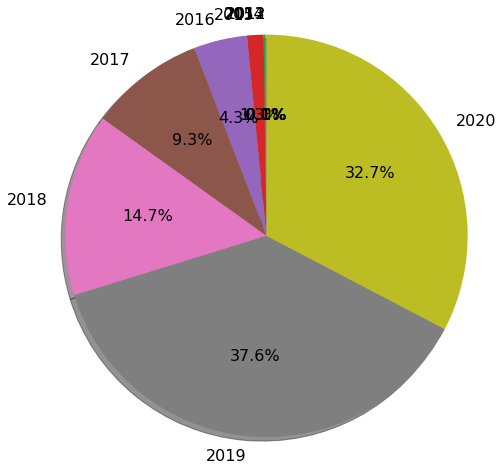

In [83]:
plot_pie_chart(posts_by_year.values(), posts_by_year.keys())

Percebe-se pelo gráfico acima que postagens dos anos 2019 e 2020 têm maior presença dentro do *dataset*. Entretanto, não é possível fazer suposições precisas sobre este fato, já que a menor quantidade de postagens em anos anteriores pode ser motivada por uma gama de fatores, como remoção de postagens por parte de autores ou do *Reddit*, menor popularidade dos *subreddits* avaliados ou menor quantidade de usuários dentro da rede social de forma geral.

### Carregamento dos resultados do treinamento

Os resultados de treinamento para os modelos do presente trabalho foram salvos em um arquivo CSV. Informações de maior complexidade, como distribuições de tópicos, palavras ou palavras pertencentes a um tópico, por sua vez, foram armazenadas em arquivos de objetos usando a biblioteca [joblib](https://joblib.readthedocs.io/en/latest/)

In [84]:
complete_lda_results = pd.read_csv(lda_results_csv)
lda_results = complete_lda_results[["k", "alpha", "beta", "c_v", "path"]]

#### Total de modelos treinados

Modelos com *k* no conjunto {3, 4, 6, 7, 8, 9} foram treinados preliminarmente. Dado que seus resultados de coerência foram baixos, desconsideraremos seu treinamento para esta avaliação:

In [85]:
print(f'Variações treinadas de modelos com 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30 tópicos: {len(lda_results)}')

lda_results = lda_results[~lda_results["k"].isin([3, 4, 6, 7, 8, 9])]

print(f'Variações treinadas de modelos com 5, 10, 15, 20, 25, 30 tópicos: {len(lda_results)}')

Variações treinadas de modelos com 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30 tópicos: 1200
Variações treinadas de modelos com 5, 10, 15, 20, 25, 30 tópicos: 600


No total, 600 modelos foram treinados considerando os critérios para a presente avaliação.

#### Modelos com maior taxa de coerência

In [86]:
results_by_c_v = lda_results.sort_values(["c_v"], ascending=(False))
results_by_c_v.head()

,k,alpha,beta,c_v,path
900,20.0,0.1,0.1,0.513358,models/lda/lda__k=20_a=0.1_b=0.1
1114,25.0,0.2,0.5,0.510016,models/lda/lda__k=25_a=0.2_b=0.5
905,20.0,0.1,0.6,0.506148,models/lda/lda__k=20_a=0.1_b=0.6
815,15.0,0.2,0.6,0.503697,models/lda/lda__k=15_a=0.2_b=0.6
1011,30.0,0.2,0.2,0.501799,models/lda/lda__k=30_a=0.2_b=0.2


In [87]:
coherence_avgs_df = lda_results.groupby(["k"]).mean()
coherence_avgs_df

,alpha,beta,c_v
k,,,
5.0,0.55,0.55,0.405721
10.0,0.55,0.55,0.431328
15.0,0.55,0.55,0.444894
20.0,0.55,0.55,0.444755
25.0,0.55,0.55,0.444917
30.0,0.55,0.55,0.443255


#### Variação de tópicos x coerência média

Por meio de um gráfico, podemos ver mais claramente a variação da coerência em relação ao incremento no valor de *k*.

In [88]:
scores = coherence_avgs_df["c_v"].to_numpy()
scores

array([0.40572085, 0.43132766, 0.44489374, 0.44475533, 0.44491714,
       0.4432552 ])

In [89]:
topics = np.sort(lda_results["k"].unique())
topics

array([ 5., 10., 15., 20., 25., 30.])

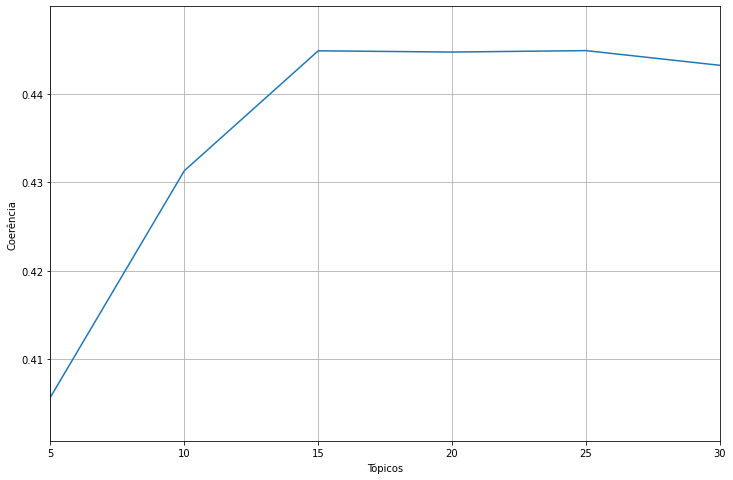

In [90]:
plot_graph(topics, scores, "Tópicos", "Coerência")

A partir do gráfico acima, constata-se que os valores de coerência subiram conforme o número de tópicos foi incrementado e passaram por uma leve queda entre os modelos de 25 e 30 tópicos. Pode-se notar ainda o aumento substancial da métrica percebido entre os modelos de 5 e 15 tópicos. Nota-se também que entre 15 e 25 tópicos os valores de coerência parecem ter estabilizado.

Na seção seguinte, avaliaremos os tópicos gerados pelo modelo em primeiro lugar no *ranking* de coerência mostrado anteriormente.

#### Modelo com 20 tópicos, alpha = 0.1 e beta = 0.1

Este modelo foi o melhor ranqueado quanto à métrica de coerência, dentre todos os modelos treinados. Abaixo, a visualização dos tópicos é realizada usando a biblioteca [pyLDAvis](https://github.com/bmabey/pyLDAvis). Tal visualização busca exibir a distância entre os tópicos gerados em um espaço bidimensional.

In [91]:
md1 = joblib.load(BASE_MODELS_PATH + "models/lda/lda__k=20_a=0.1_b=0.1") 
topics_df1 = create_dataframe_from_topics(md1['topic_word_dist'], md1['idx_to_word'])
pyLDAvis.sklearn.prepare(md1["instance"], joblib.load(BASE_MODELS_PATH + md1["vectorized_docs_path"]), md1["vectorizer"])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.005539  0.032823       1        1  11.672306
3     -0.011913  0.055297       2        1   8.438890
17     0.089977 -0.040544       3        1   7.798075
9      0.080129 -0.021410       4        1   7.136132
12     0.087499 -0.012994       5        1   7.126400
0      0.061016 -0.005291       6        1   5.977172
10    -0.011233 -0.011793       7        1   5.511244
1     -0.114208 -0.161675       8        1   5.411433
18    -0.206651  0.109012       9        1   5.302822
16     0.013213  0.146212      10        1   4.978794
5     -0.125306  0.051054      11        1   4.890686
15     0.149887 -0.022437      12        1   3.636379
2      0.107908  0.048703      13        1   3.547988
7      0.023094  0.108267      14        1   3.416186
8     -0.073077 -0.157488      15        1   3.403924
13    -0.053392 -0.084439      16        1   2.932762
14     0.123895  0.050870      17        1   2.521068
4     -0.154185  0.079841      18        1   2.346264
6      0.013536  0.018416      19        1   2.298396
11    -0.005727 -0.182424      20        1   1.653081, topic_info=         Term         Freq        Total Category  logprob  loglift
548    pessoa  3285.000000  3285.000000  Default  30.0000  30.0000
34     amigar   578.000000   578.000000  Default  29.0000  29.0000
200    cursar   442.000000   442.000000  Default  28.0000  28.0000
677    sentir  1095.000000  1095.000000  Default  27.0000  27.0000
35      amigo  1082.000000  1082.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
719     tempo    24.854593  2219.093520  Topic20  -4.1614  -0.3893
558    pontar    15.982658   440.554165  Topic20  -4.6029   0.7860
478     mundo    16.205523   756.136009  Topic20  -4.5891   0.2597
692  situacao    14.757381   520.164604  Topic20  -4.6827   0.5401
447      medo    12.987481   776.699642  Topic20  -4.8105   0.0115

[1105 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.169209   abraco
0         2  0.092296   abraco
0         3  0.153827   abraco
0         4  0.092296   abraco
0         6  0.092296   abraco
...     ...       ...      ...
772      20  0.004589  vontade
773       1  0.352388    zonar
773       3  0.105716    zonar
773       6  0.035239    zonar
773      12  0.422866    zonar

[5408 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 4, 18, 10, 13, 1, 11, 2, 19, 17, 6, 16, 3, 8, 9, 14, 15, 5, 7, 12])

Parte dos tópicos é difícil de descrever, dado que não possuem significado claro e agregam termos com pouquíssima relação entre si. Tais tópicos são chamados comumente de *junk topics*. Pode-se enumerar tópicos como o 16, 8, 20 e 7 como exemplares desse tipo de tópico.

Contudo, percebe-se que outros tópicos agregam significados mais interessantes. Um olhar mais aprofundado será dispensado a esses tópicos.

##### Tópicos rotuláveis

As visualizações de nuvens de palavras a seguir são realizadas por meio da *lib* [wordcloud](https://github.com/amueller/word_cloud).
Primeiramente, é preciso obter o mapeamento de palavras e sua distribuição não-normalizada dentro dos tópicos:

In [92]:
topic_word_probability_pairs = get_topic_word_probability_pairs(md1['topic_word_dist'], md1['idx_to_word'])

Além disso, é interessante visualizar uma tabela mostrando os termos mais frequentes de cada tópico. A tabela abaixo mostra os 10 termos mais frequentes para cada tópico:

In [93]:
topics_df1

,palavras
0,pessoa casar voces situacao contar tempo ajudar sentir momento desabafar
1,pessoa partir criancas filhar crianca senhor poder policiar nome morte
2,amigar pessoa amigo suicidio medo amizade mensagem tempo grupar pensar
3,gente namorar tempo casar pessoa caro relacionamento familia semana empregar
4,aula sala escola casar amigar facebook carro horar tempo contar
5,trabalhar empregar empresar casar situacao tempo dinheiro estagiar salariar faculdade
6,pessoa sentir provar mundo ajudar ninguem texto vezar lista situacao
7,tempo crise problema ansiedade relacionamento pornografia semana falto pessoa medicar
8,tempo formar mundo sociedade sentimento liberdade suicidio realidade trabalhar projeto
9,pessoa tempo garoto vezar drogar sentimento verdade mentir problema formar


De posse desse mapeamento e considerando a numeração de tópicos representada pela tabela acima, é possível gerar as nuvens de palavras. A primeira delas será para o tópico 18, que parece abordar <strong>vida estudantil</strong>:

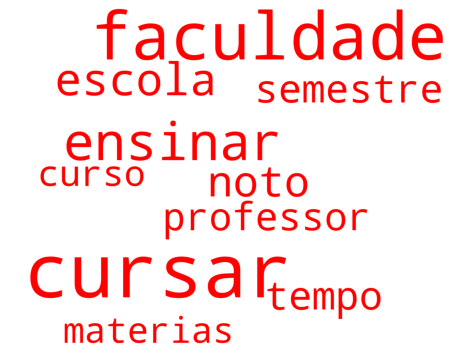

In [94]:
plot_wordcloud_by_word_probability(topic_word_probability_pairs[18], "red")

O tópico 5 reúne termos associados a <strong>vida profissional</strong>.

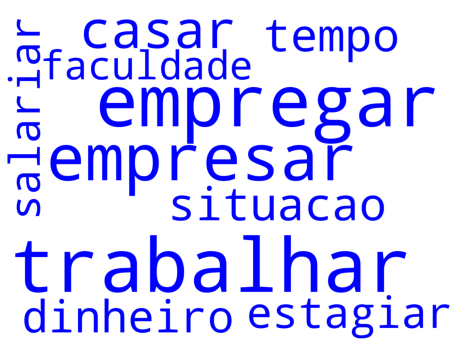

In [95]:
plot_wordcloud_by_word_probability(topic_word_probability_pairs[5], "blue")

O tópico 16 parece abordar <strong>acompanhamento de saúde mental e manifestações de doença mental</strong>.

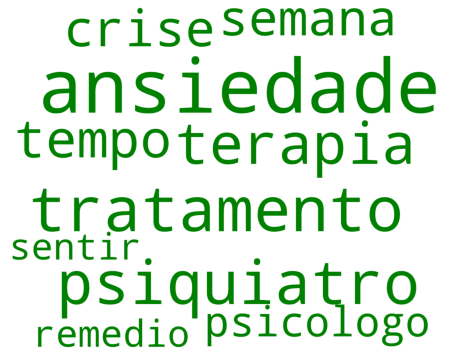

In [96]:
plot_wordcloud_by_word_probability(topic_word_probability_pairs[16], "green")

O tópico 12 reúne termos que indicam <strong>introspecção e preocupações mórbidas</strong> angústia emocional, remorso, tendência ao suicídio e etc.

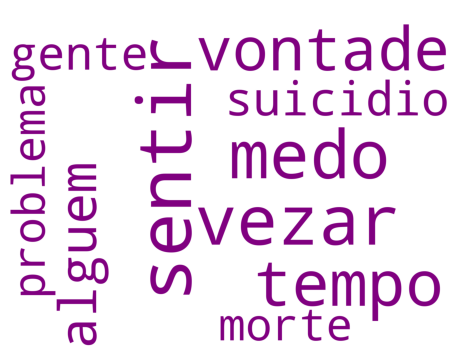

In [97]:
plot_wordcloud_by_word_probability(topic_word_probability_pairs[12], "purple")

O tópico 8 não é de fácil rotulação, mas parece associar termos relativos a <strong>aspectos de sociedade</strong>.

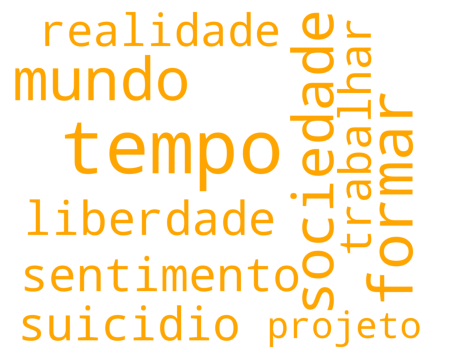

In [98]:
plot_wordcloud_by_word_probability(topic_word_probability_pairs[8], "orange")

O tópico 2, de alguma maneira, parece associar termos que podem indicar <strong>amizade com indivíduos depressivos</strong>.

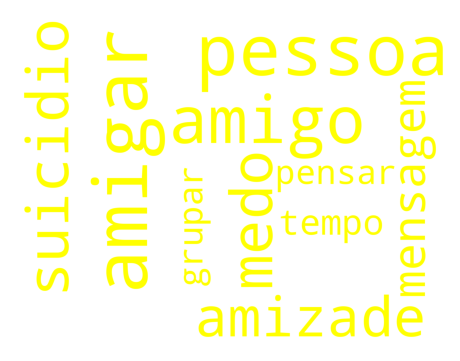

In [99]:
plot_wordcloud_by_word_probability(topic_word_probability_pairs[2], "yellow")

Por fim, algo interessante a se avaliar é o número de palavras no vocabulário do modelo treinado:

In [100]:
print(f'Total de palavras no vocabulário: {len(md1["vectorizer"].vocabulary_)} \nTotal de palavras removidas: {len(md1["vectorizer"].stop_words_)}')

Total de palavras no vocabulário: 774 
Total de palavras removidas: 8422


### Conclusões

Considerado o modelo avaliado, percebe-se que tópicos associados a depressão foram devidamente identificados. Os tópicos descritos são indicativos de propensão ao desenvolvimento do distúrbio ou relacionam conceitos associados ao transtorno depressivo maior - como é o caso do tópico sobre acompanhamento de saúde mental. O resultado é de especial importância dado que foi observado mesmo em um *corpus* de tamanho bastante reduzido.

Contudo, tal *dataset* deve ser expandido de forma que avaliações mais precisas possam ser feitas em relação ao conteúdo sobre depressão encontrado no *Reddit*. Um ponto que corrobora com este fato é a ocorrência significativa de *junk topics* no modelo descrito, o que indica que o LDA não conseguiu associar termos a esses tópicos de maneira especialmente adequada.

De qualquer forma, os resultados observados são promissores e apontam para um caminho interessante no âmbito da identificação de tópicos depressivos por meio das redes sociais.